# Pytorch starter - FasterRCNN Train
In this notebook I enabled the GPU and the Internet access (needed for the pre-trained weights). We can not use Internet during inference, so I'll create another notebook for commiting. Stay tuned!

You can find the [inference notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)

https://pytorch.org/vision/main/models.html


In [1]:
# !pip install albumentations

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

from sklearn.metrics import average_precision_score
from tqdm import tqdm

# import rasterio

DIR_INPUT = '../datasets/01m-All-1'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
NUM_CHANNELS = 3 # Number of input image channels RGB + Extras
NUM_CLASSES = 6 # Number of classes in the dataset

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:

class YOLOTifDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (str): Directory containing `images/`, `labels/`, and `edge_images/` subdirectories.
            transforms (callable, optional): A function/transform to apply to the images.
        """
        self.image_dir = os.path.join(root_dir, "old_images")
        # self.priviliged_dir = os.path.join(root_dir, "edge_images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.transforms = transforms
        self.image_filenames = [f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        # self.priviliged_filenames = [f for f in os.listdir(self.priviliged_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        img_filename = self.image_filenames[idx]
        # priviliged_filename = self.priviliged_filenames[idx]

        img_path = os.path.join(self.image_dir, img_filename)
        # priviliged_path = os.path.join(self.priviliged_dir, priviliged_filename)

        # Load images using OpenCV and convert from BGR to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0  # Normalize image to [0, 1]

        # priviliged = cv2.imread(priviliged_path, cv2.IMREAD_GRAYSCALE)
        # priviliged = priviliged.astype(np.float32) / 255.0  # Normalize privileged image to [0, 1]

        # Convert to PyTorch tensors
        img_tensor = torch.tensor(img).permute(2, 0, 1)  # Convert to (C, H, W) for RGB image
        # priviliged_tensor = torch.tensor(priviliged).unsqueeze(0)  # Add channel dimension (1, H, W) for privileged image

        # Concatenate the privileged image with the original image
        # img = torch.cat((img_tensor, priviliged_tensor), dim=0)  # Shape will be (C+1, H, W)
        img = img_tensor

        # Load YOLO annotations
        label_filename = img_filename.rsplit('.', 1)[0] + '.txt'  # Replace image extension with .txt
        label_path = os.path.join(self.label_dir, label_filename)

        boxes = []
        labels = []
        target_ids = []  # Add target_id for each instance

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    values = list(map(float, line.strip().split()))
                    class_id = int(values[0])
                    annotations = values[1:]

                    # If annotations are polygonal (more than 4 coordinates), use enclosing bounding box
                    if len(annotations) > 4:
                        box_coords = np.array(annotations).reshape(-1, 2)
                        x_min = np.min(box_coords[:, 0])
                        y_min = np.min(box_coords[:, 1])
                        x_max = np.max(box_coords[:, 0])
                        y_max = np.max(box_coords[:, 1])
                    else:
                        # Center format (YOLO format: x_center, y_center, width, height)
                        x_center, y_center, w, h = annotations

                        # Convert to Pascal VOC (x_min, y_min, x_max, y_max)
                        x_min = x_center - w / 2
                        y_min = y_center - h / 2
                        x_max = x_center + w / 2
                        y_max = y_center + h / 2

                    # Scale coordinates from between 0 and 1 to the image size (Pascal VOC format which is needed for Faster R-CNN)
                    x_min *= img.shape[2]
                    y_min *= img.shape[1]
                    x_max *= img.shape[2]
                    y_max *= img.shape[1]

                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id)
                    target_ids.append(len(boxes) - 1)  # Add target_id for each instance

        # COCO-style dictionary format 
        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),  # Bounding boxes (x_min, y_min, x_max, y_max)
            'labels': torch.tensor(labels, dtype=torch.int64),  # Class IDs
            'image_id': torch.tensor([idx]),  # Image ID (index of the image)
            'area': torch.tensor([(box[2] - box[0]) * (box[3] - box[1]) for box in boxes], dtype=torch.float32),  # Area of the box
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)  # Assume all instances are not crowd
        }

        # Apply data augmentation if available
        if self.transforms:
            sample = {'image': img, 'bboxes': target['boxes'], 'labels': target['labels']}
            sample = self.transforms(sample)
            img = sample['image']
            target['boxes'] = sample['bboxes']
            target['labels'] = sample['labels']

        return img, target

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define train and validation transformations
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),  # Flip images horizontally with a probability of 0.5
        A.VerticalFlip(p=0.5),    # Optionally, flip images vertically (remove if not needed)
        ToTensorV2(p=1.0)         # Ensure the image is converted to a tensor
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)         # Ensure the image is converted to a tensor
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Example usage with images that have more than 3 channels
def transform_image(image, transform):
    # Example: If your image has more than 3 channels, ensure to specify the number of channels
    augmented = transform(image=image)
    return augmented['image']  # Return the augmented image (tensor)


# Create the model

In [5]:
# load a model; pre-trained on COCO
# Load the FasterRCNN model with pretrained weights
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

# Modify the first convolutional layer for 4-channel input
model.backbone.body.conv1 = torch.nn.Conv2d(NUM_CHANNELS, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Dynamically set image mean and std for 4-channel input
model.transform.image_mean = [0.485] * NUM_CHANNELS
model.transform.image_std = [0.229] * NUM_CHANNELS

# Get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Freeze all parameters except for the first convolutional layer and the last layer for predictions
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the first convolutional layer
for param in model.backbone.body.conv1.parameters():
    param.requires_grad = True

# Unfreeze the classifier (last layer) for predictions
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

# Move the model to the correct device (e.g., CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Verify the model structure
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = YOLOTifDataset(DIR_TRAIN)#, get_train_transform())
valid_dataset = YOLOTifDataset(DIR_VALID)#, get_valid_transform())
test_dataset = YOLOTifDataset(DIR_TEST)#, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
batch_size = 4
num_workers = 0

torch.multiprocessing.set_start_method('spawn')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
)

test_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
)

In [8]:
images, targets= train_data_loader.dataset[0]
print(images.shape, targets)

torch.Size([3, 3024, 4032]) {'boxes': tensor([[1458.0000, 1186.0000, 1976.0000, 2010.0000],
        [3413.3333, 2600.0000, 3913.3333, 3024.0000]]), 'labels': tensor([2, 0]), 'image_id': tensor([0]), 'area': tensor([426832., 212000.]), 'iscrowd': tensor([0, 0])}


# Sample

In [9]:
images, targets, = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

(3024, 4032, 3)


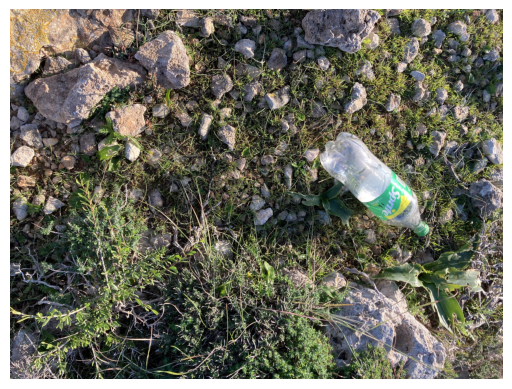

In [10]:
# Extract and reshape the image for the 2nd sample
sample_image = images[0].cpu().numpy()

# Keep only the first 3 RGB channels
red_channel = sample_image[0]
green_channel = sample_image[1]
blue_channel = sample_image[2]
# Edge channel will be ignored for now
# edge_channel = sample_image[3]

red_channel = (red_channel * 255).astype(np.uint8)
green_channel = (green_channel * 255).astype(np.uint8)
blue_channel = (blue_channel * 255).astype(np.uint8)

# Stack the channels to form the RGB image
sample_image_rgb = np.stack([red_channel, green_channel, blue_channel], axis=-1)

print(sample_image_rgb.shape)  # This should give you (height, width, 3) for RGB channels

# Plot the image using Matplotlib
plt.imshow(sample_image_rgb)
plt.axis('off')
plt.show()


In [11]:
targets

[{'boxes': tensor([[2503.3333,  966.6667, 3453.3333, 1880.0000]], device='cuda:0'),
  'labels': tensor([0], device='cuda:0'),
  'image_id': tensor([66], device='cuda:0'),
  'area': tensor([867666.6875], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[3166.6667,  980.0000, 3796.6667, 1533.3334]], device='cuda:0'),
  'labels': tensor([5], device='cuda:0'),
  'image_id': tensor([47], device='cuda:0'),
  'area': tensor([348600.], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[ 522.5000,  900.0000, 1087.5000, 1160.0000]], device='cuda:0'),
  'labels': tensor([0], device='cuda:0'),
  'image_id': tensor([194], device='cuda:0'),
  'area': tensor([146900.], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[3225.,  655., 3925.,  940.],
          [2810., 1560., 3515., 1890.],
          [1795., 2610., 2220., 3024.]], device='cuda:0'),
  'labels': tensor([3, 3, 0], device='cuda:0'),
  'image_id': te

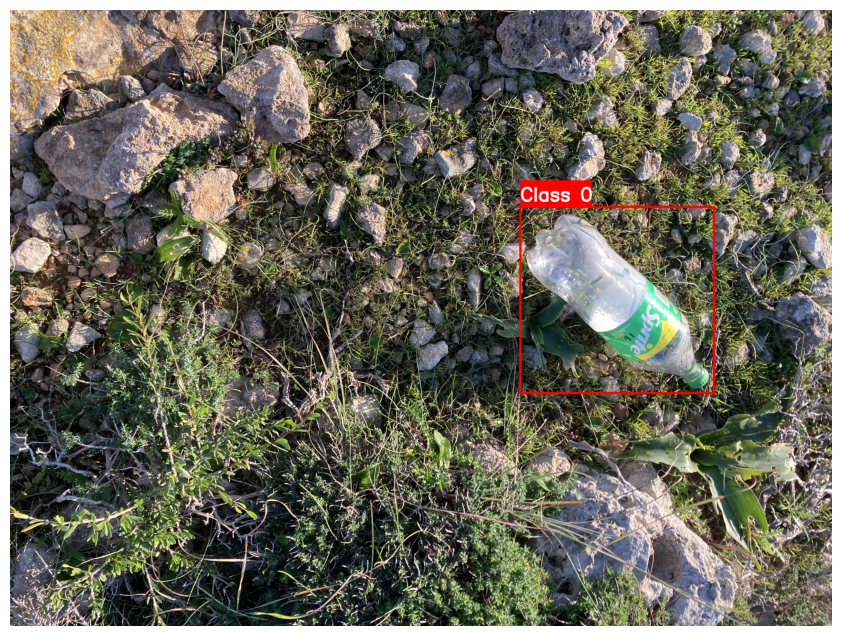

In [12]:
# Assuming `targets` is the list of dictionaries and `sample_image_rgb` is your image
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Convert the image to uint8 (if not already in that format)
sample_image_rgb = sample_image_rgb.astype(np.uint8)

# Iterate over all the targets (boxes and labels)
target = targets[0]  # Example with the first target

boxes = target['boxes'].cpu().numpy()  # Move boxes from GPU to CPU and convert to NumPy
labels = target['labels'].cpu().numpy()  # Get the labels for each box

# Iterate through all the boxes and labels
for i, box in enumerate(boxes):
    # The box is in the format [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = box

    # Convert the coordinates to integers
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Draw the rectangle (bounding box) on the image
    cv2.rectangle(sample_image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 10)

    # Draw the class label text
    class_id = labels[i]  # Class ID for the current box
    class_name = f'Class {class_id}'  # Class label name

    # Get the size of the text to adjust the background rectangle for text
    text_height = 100
    text_width = len(class_name) * 50

    # Draw the background rectangle for the class label text
    cv2.rectangle(sample_image_rgb, (x_min, y_min - int(1.3 * text_height)),
                  (x_min + text_width, y_min), (255, 0, 0), -1)

    # Put the class name text (make it bold and white)
    cv2.putText(sample_image_rgb, class_name, (x_min, y_min - int(0.3 * text_height)),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), thickness=10, lineType=cv2.LINE_AA)

# Remove axis for clarity in plotting
ax.set_axis_off()
ax.imshow(sample_image_rgb)
plt.show()


# Train

In [13]:
# Extract trainable parameters
params = [p for p in model.parameters() if p.requires_grad]
print("Length of trainable parameters: ", len(params))

# Optimizer: AdamW is often better for convergence in object detection models
# AdamW decouples weight decay from the learning rate, improving performance
optimizer = torch.optim.AdamW(params, lr=0.001, weight_decay=0.01)# Previous lr was 0.0001

# Learning rate scheduler: ReduceLROnPlateau adapts learning rate based on validation loss
# More adaptive than StepLR
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5, verbose=True
)

# Early stopping criteria: Patience can be higher for complex models to avoid premature stopping
early_stopping_patience = 5  # Number of epochs without improvement
best_loss = float('inf')
early_stopping_counter = 0

# Number of epochs
num_epochs = 100
loss_hist = Averager()
batch = 1

# output is not being generated, maybe check for other models such as SSD and check bounding box format in dataset maybe that could be the problem

Length of trainable parameters:  5


c:\Users\User\anaconda3\envs\yolov10\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
epoch_losses = []
val_epoch_losses = []
loss_dict_values = []

for epoch in range(num_epochs):
    model.train()
    loss_hist.reset()
    loss_values = []  # Collect batch losses for epoch averaging
    
    start_time = time.time()  # Measure epoch time
    avg_loss_dict = {}  # Average the loss dictionary values

    # Training loop
    total_iterations = len(train_data_loader)
    with tqdm(total=total_iterations, unit=" batch", desc=f"Epoch #{epoch+1}/{num_epochs} (Train)") as tepoch:
        for batch, (images, targets) in enumerate(train_data_loader, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)

            # Update the Average loss dictionary
            if not avg_loss_dict:
                avg_loss_dict = {k: [v.item()] for k, v in loss_dict.items()}
            else:
                avg_loss_dict = {k: v + [loss_dict[k].item()] for k, v in avg_loss_dict.items()}

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_values.append(loss_value)  # Track batch loss
            
            # Backward pass and optimizer step
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Update tqdm description and increment progress
            tepoch.set_postfix(
                batch=batch, 
                batch_loss=loss_value, 
                loss_cls=loss_dict['loss_classifier'].item(), 
                loss_box=loss_dict['loss_box_reg'].item(),
                loss_obj=loss_dict['loss_objectness'].item(),
                loss_rpn=loss_dict['loss_rpn_box_reg'].item()
            )
            tepoch.update(1)  # Increment tqdm for each batch

        # Average the loss dictionary values
        avg_loss_dict = {k: np.mean(v) for k, v in avg_loss_dict.items()}
        loss_dict_values.append(avg_loss_dict)

        # Scheduler step (if provided)
        if lr_scheduler:
            lr_scheduler.step(np.mean(loss_values))

        # Average epoch loss and logging
        epoch_loss_value = np.mean(loss_values)
        epoch_losses.append(epoch_loss_value)

        # Measure epoch time
        time_elapsed = time.time() - start_time

        tepoch.set_postfix(
            epoch_loss=epoch_loss_value,
            epoch_time=f"{time_elapsed // 60:.0f}m.{time_elapsed % 60:.0f}s"
        )

    # Validation loop
    # model.eval()
    val_loss_values = []
    with torch.no_grad():
        with tqdm(total=len(test_data_loader), unit=" batch", desc=f"Epoch #{epoch+1}/{num_epochs} (Validation)") as vepoch:
            for images, targets in test_data_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Forward pass
                loss_dict = model(images, targets)
                val_loss = sum(loss for loss in loss_dict.values()).item()
                val_loss_values.append(val_loss)

                vepoch.set_postfix(batch_loss=val_loss)
                vepoch.update(1)

    # Average validation loss
    val_epoch_loss = np.mean(val_loss_values)
    val_epoch_losses.append(val_epoch_loss)

    print(f"Epoch {epoch + 1}: Train Loss: {epoch_loss_value:.4f}, Validation Loss: {val_epoch_loss:.4f}, Early stopping counter: {early_stopping_counter}")

    # Early stopping condition
    if val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

Epoch #1/100 (Validation): 100%|██████████| 23/23 [00:17<00:00,  1.34 batch/s, batch_loss=0.214]


Epoch 1: Train Loss: 0.3135, Validation Loss: 0.2459, Early stopping counter: 0


Epoch #2/100 (Validation): 100%|██████████| 23/23 [00:12<00:00,  1.90 batch/s, batch_loss=0.212] 


Epoch 2: Train Loss: 0.2144, Validation Loss: 0.2095, Early stopping counter: 0


Epoch #3/100 (Validation): 100%|██████████| 23/23 [00:16<00:00,  1.36 batch/s, batch_loss=0.198] 


Epoch 3: Train Loss: 0.1930, Validation Loss: 0.1794, Early stopping counter: 0


Epoch #4/100 (Validation): 100%|██████████| 23/23 [00:16<00:00,  1.36 batch/s, batch_loss=0.142] 


Epoch 4: Train Loss: 0.1807, Validation Loss: 0.2031, Early stopping counter: 0


Epoch #5/100 (Validation): 100%|██████████| 23/23 [00:16<00:00,  1.37 batch/s, batch_loss=0.177] 


Epoch 5: Train Loss: 0.1692, Validation Loss: 0.1662, Early stopping counter: 1


Epoch #6/100 (Validation): 100%|██████████| 23/23 [00:16<00:00,  1.35 batch/s, batch_loss=0.151] 


Epoch 6: Train Loss: 0.1589, Validation Loss: 0.1637, Early stopping counter: 0


Epoch #7/100 (Validation): 100%|██████████| 23/23 [00:17<00:00,  1.34 batch/s, batch_loss=0.173] 


Epoch 7: Train Loss: 0.1485, Validation Loss: 0.1594, Early stopping counter: 0


Epoch #8/100 (Validation): 100%|██████████| 23/23 [00:17<00:00,  1.34 batch/s, batch_loss=0.201] 


Epoch 8: Train Loss: 0.1476, Validation Loss: 0.1788, Early stopping counter: 0


Epoch #9/100 (Validation): 100%|██████████| 23/23 [00:17<00:00,  1.34 batch/s, batch_loss=0.175] 


Epoch 9: Train Loss: 0.1418, Validation Loss: 0.1669, Early stopping counter: 1


Epoch #10/100 (Validation): 100%|██████████| 23/23 [00:17<00:00,  1.34 batch/s, batch_loss=0.171] 


Epoch 10: Train Loss: 0.1390, Validation Loss: 0.1563, Early stopping counter: 2


Epoch #11/100 (Validation): 100%|██████████| 23/23 [00:09<00:00,  2.44 batch/s, batch_loss=0.183] 


Epoch 11: Train Loss: 0.1293, Validation Loss: 0.1585, Early stopping counter: 0


Epoch #12/100 (Validation): 100%|██████████| 23/23 [00:14<00:00,  1.64 batch/s, batch_loss=0.17]  


Epoch 12: Train Loss: 0.1261, Validation Loss: 0.1603, Early stopping counter: 1


Epoch #13/100 (Validation): 100%|██████████| 23/23 [00:10<00:00,  2.21 batch/s, batch_loss=0.186] 


Epoch 13: Train Loss: 0.1228, Validation Loss: 0.1536, Early stopping counter: 2


Epoch #14/100 (Validation): 100%|██████████| 23/23 [00:13<00:00,  1.67 batch/s, batch_loss=0.166] 


Epoch 14: Train Loss: 0.1236, Validation Loss: 0.1657, Early stopping counter: 0


Epoch #15/100 (Validation): 100%|██████████| 23/23 [00:17<00:00,  1.34 batch/s, batch_loss=0.201] 


Epoch 15: Train Loss: 0.1197, Validation Loss: 0.1532, Early stopping counter: 1


Epoch #16/100 (Validation): 100%|██████████| 23/23 [00:17<00:00,  1.34 batch/s, batch_loss=0.171] 


Epoch 16: Train Loss: 0.1143, Validation Loss: 0.1546, Early stopping counter: 0


Epoch #17/100 (Validation): 100%|██████████| 23/23 [00:12<00:00,  1.89 batch/s, batch_loss=0.172] 


Epoch 17: Train Loss: 0.1114, Validation Loss: 0.1420, Early stopping counter: 1


Epoch #18/100 (Validation): 100%|██████████| 23/23 [00:14<00:00,  1.63 batch/s, batch_loss=0.147] 


Epoch 18: Train Loss: 0.1084, Validation Loss: 0.1458, Early stopping counter: 0


Epoch #19/100 (Validation): 100%|██████████| 23/23 [00:09<00:00,  2.46 batch/s, batch_loss=0.165] 


Epoch 19: Train Loss: 0.1088, Validation Loss: 0.1490, Early stopping counter: 1


Epoch #20/100 (Validation): 100%|██████████| 23/23 [00:16<00:00,  1.36 batch/s, batch_loss=0.191] 


Epoch 20: Train Loss: 0.1071, Validation Loss: 0.1606, Early stopping counter: 2


Epoch #21/100 (Validation): 100%|██████████| 23/23 [00:14<00:00,  1.63 batch/s, batch_loss=0.15]  


Epoch 21: Train Loss: 0.1112, Validation Loss: 0.1478, Early stopping counter: 3


Epoch #22/100 (Validation): 100%|██████████| 23/23 [00:14<00:00,  1.64 batch/s, batch_loss=0.207] 

Epoch 22: Train Loss: 0.1096, Validation Loss: 0.1792, Early stopping counter: 4
Early stopping triggered.


In [15]:
# Convert the loss dictionary values to a dictionary with 4 lists
loss_dict_values = {k: [d[k] for d in loss_dict_values] for k in loss_dict_values[0].keys()}

# Tranfer the keys to capital and remove underscores for better visualization
loss_dict_values = {k.replace('_', ' ').title(): v for k, v in loss_dict_values.items()}

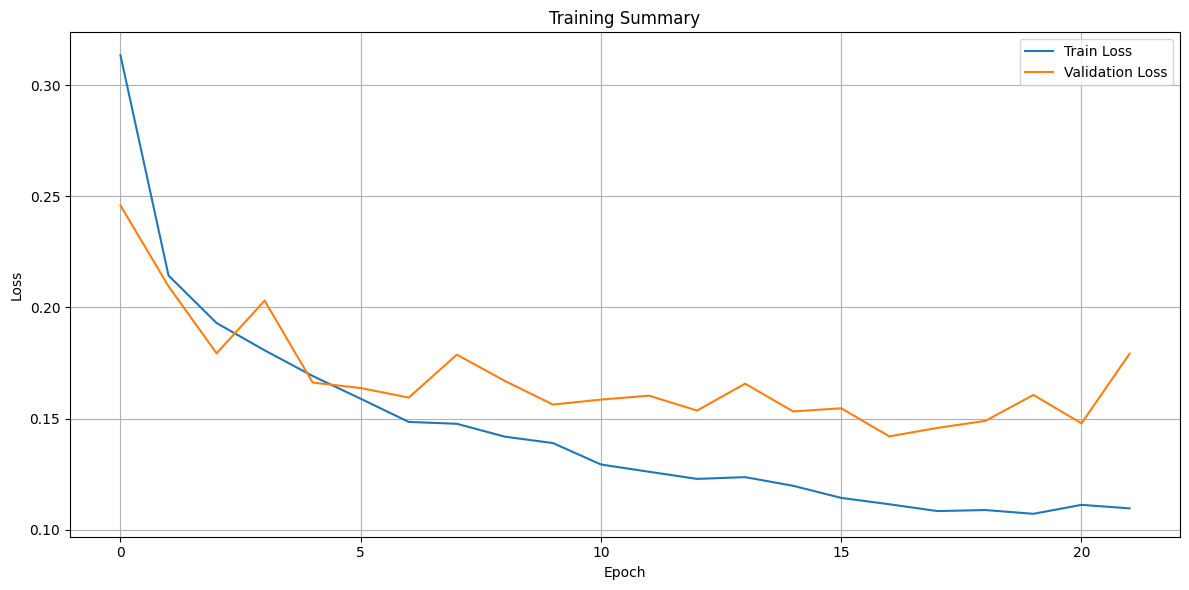

In [16]:
# Display a plot of the loss values
plt.figure(figsize=(12, 6))
plt.plot(epoch_losses, label='Train Loss')
plt.plot(val_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Summary')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

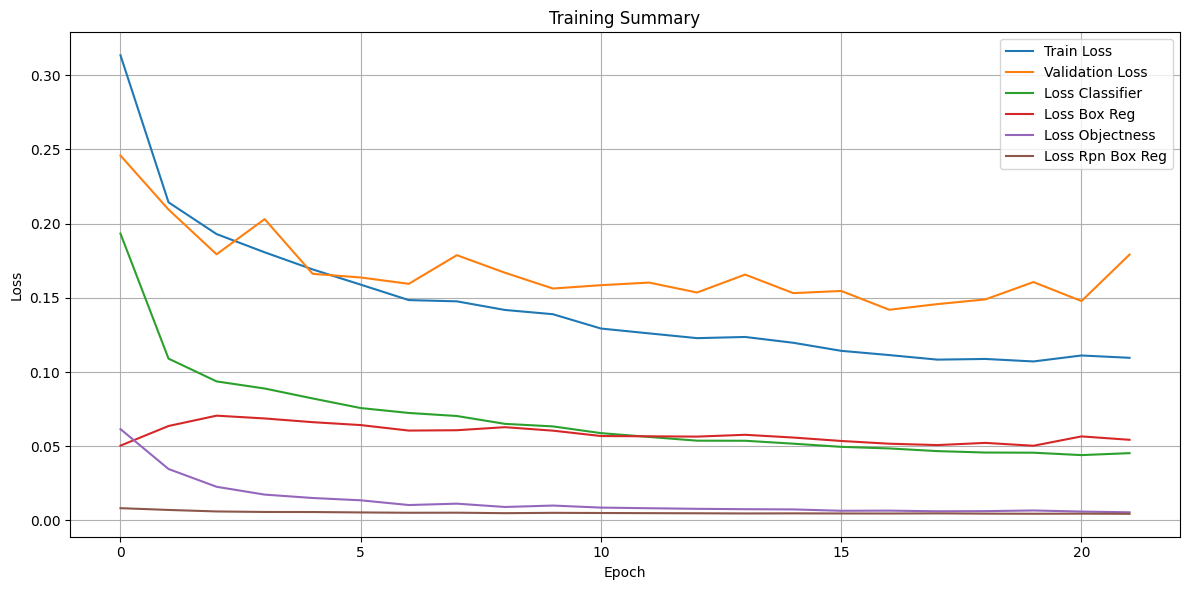

In [17]:
# Display a plot of the loss values
plt.figure(figsize=(12, 6))
plt.plot(epoch_losses, label='Train Loss')
plt.plot(val_epoch_losses, label='Validation Loss')

# Plot the separate losses
for k in loss_dict_values.keys():
    plt.plot(loss_dict_values[k], label=k)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Summary')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
loss_dict

{'loss_classifier': tensor(0.0637, device='cuda:0'),
 'loss_box_reg': tensor(0.1189, device='cuda:0'),
 'loss_objectness': tensor(0.0131, device='cuda:0'),
 'loss_rpn_box_reg': tensor(0.0115, device='cuda:0')}

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from torchvision.ops import box_iou
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

def plot_normalized_confusion_matrix(all_preds, all_labels, class_names):
    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
    
    # Customize plot
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

def plot_precision_recall_curve(all_preds, all_labels, num_classes, class_names):
    # Binarize the labels for multiclass classification
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))
    
    # Compute precision-recall curve for each class
    plt.figure(figsize=(10, 8))
    
    for class_idx in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_labels_bin[:, class_idx], all_preds == class_idx)
        
        # Plot the precision-recall curve for the current class
        plt.plot(recall, precision, label=f'Class {class_idx}: {class_names[class_idx]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def calculate_map(model, valid_data_loader, device, num_classes=6, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    model.eval()

    all_preds = []
    all_labels = []
    all_scores = []

    # Initialize a tqdm progress bar
    with torch.no_grad():
        for images, targets in tqdm(valid_data_loader, desc="Evaluating", unit=" batch"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions from the model
            output = model(images)

            # Iterate over each image in the batch
            for i in range(len(output)):
                pred_boxes = output[i]["boxes"].cpu().numpy()
                pred_labels = output[i]["labels"].cpu().numpy()
                pred_scores = output[i]["scores"].cpu().numpy()

                true_boxes = targets[i]["boxes"].cpu().numpy()
                true_labels = targets[i]["labels"].cpu().numpy()

                # Filter predictions based on score threshold (e.g., 0.5)
                keep = pred_scores >= 0.5
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                # Match predicted boxes with true boxes based on IoU
                iou = box_iou(torch.tensor(pred_boxes), torch.tensor(true_boxes))

                for j in range(len(pred_boxes)):
                    # Get the best IoU match for this prediction
                    max_iou, max_idx = iou[j].max(0)
                    if max_iou >= 0.5:  # IoU threshold for matching
                        all_preds.append(pred_labels[j])  # Predicted class label
                        all_labels.append(true_labels[max_idx])  # True class label
                        all_scores.append(pred_scores[j])  # Prediction score

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)

    if len(all_labels) == 0:
        return pd.DataFrame()  # No objects detected in the validation set

    # Binarize the labels
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Calculate AP for each category (class)
    ap_per_class = []
    ap50_per_class = []
    ap75_per_class = []

    for class_idx in range(num_classes):
        # Calculate AP for each class (standard)
        ap = average_precision_score(all_labels_bin[:, class_idx], all_scores)
        ap_per_class.append(ap)

        # For AP50, calculate based on IoU threshold of 0.5
        keep_50 = iou >= 0.5  # Only keep predictions with IoU >= 0.5
        ap50 = average_precision_score(all_labels_bin[:, class_idx], all_scores)  # This line needs to use the binary labels
        ap50_per_class.append(ap50)

        # For AP75, calculate based on IoU threshold of 0.75
        keep_75 = iou >= 0.75  # Only keep predictions with IoU >= 0.75
        ap75 = average_precision_score(all_labels_bin[:, class_idx], all_scores)  # Similar correction as AP50
        ap75_per_class.append(ap75)

    # Create a DataFrame for easy visualization of AP for each class and the total mAP
    ap_df = pd.DataFrame({
        "Class": [f"Class {i}" for i in range(num_classes)],
        "AP": ap_per_class,
        "AP50": ap50_per_class,
        "AP75": ap75_per_class
    })

    # Calculate mAP (mean average precision)
    mAP = np.mean(ap_per_class)
    mAP50 = np.mean(ap50_per_class)
    mAP75 = np.mean(ap75_per_class)

    # Add the mAP rows for overall mAP values
    ap_df = pd.concat([ap_df, pd.DataFrame({"Class": ["mAP"], "AP": [mAP], "AP50": [mAP50], "AP75": [mAP75]})], ignore_index=True)

    print("\nAverage Precision Scores (AP) for each class, AP50, AP75, and mAP:")
    print(ap_df)

    return ap_df, mAP, mAP50, mAP75, all_preds, all_labels

def plot_ap_bars(ap_df, iou_thresholds, class_names):
    # Add "mAP" class name for the last row
    class_names_with_map = class_names + ['mAP']  # Add 'mAP' to the class names
    
    # Set class names as the index
    ap_df = ap_df.set_index(pd.Index(class_names_with_map))  # Now matches the length of class names

    # Create a bar plot from the DataFrame
    ax = ap_df.plot(kind='bar', figsize=(12, 8), width=0.8, colormap='viridis')

    # Customize the plot
    ax.set_xlabel("Class")
    ax.set_ylabel("Average Precision (AP)")
    ax.set_title("AP Scores per Class at Different IoU Thresholds")
    ax.set_xticklabels(class_names_with_map, rotation=45)
    plt.xticks(np.arange(len(class_names_with_map)))
    plt.legend(title="IoU Thresholds", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


# Calculate precision, recall, and F1 score for each class and overall
def calculate_precision_recall_f1(all_preds, all_labels, num_classes=6):
    precision = []
    recall = []
    f1 = []
    
    for class_idx in range(num_classes):
        precision_class = precision_score(all_labels, all_preds, labels=[class_idx], average='macro', zero_division=0)
        recall_class = recall_score(all_labels, all_preds, labels=[class_idx], average='macro', zero_division=0)
        f1_class = f1_score(all_labels, all_preds, labels=[class_idx], average='macro', zero_division=0)
        
        precision.append(precision_class)
        recall.append(recall_class)
        f1.append(f1_class)

    # Calculate mean precision, recall, and F1 score
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)

    print("\nPrecision, Recall, F1 Scores per Class:")
    precision_recall_f1_df = pd.DataFrame({
        'Class': [f'Class {i}' for i in range(num_classes)],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    print(precision_recall_f1_df)

    # Print mean scores
    print(f"\nMean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f}")

# Example usage in the main evaluation function
def evaluate(model, valid_data_loader, device, class_names):
    # Calculate mAP and AP scores for each IoU threshold
    ap_df, mAP, mAP50, mAP75, all_preds, all_labels = calculate_map(model, valid_data_loader, device, num_classes=NUM_CLASSES)
    
    # Plot the AP bar graph for each class
    plot_ap_bars(ap_df, iou_thresholds=np.arange(0.5, 1.0, 0.05), class_names=class_names)

    # Plot the normalized confusion matrix
    plot_normalized_confusion_matrix(all_preds, all_labels, class_names)

    # Plot the precision-recall curve
    plot_precision_recall_curve(all_preds, all_labels, num_classes=NUM_CLASSES, class_names=class_names)
    
    # Calculate precision, recall, and F1 score for each class
    calculate_precision_recall_f1(all_preds, all_labels, num_classes=NUM_CLASSES)



Evaluating: 100%|██████████| 23/23 [00:14<00:00,  1.61 batch/s]


Average Precision Scores (AP) for each class, AP50, AP75, and mAP:
     Class        AP      AP50      AP75
0  Class 0  0.076030  0.076030  0.076030
1  Class 1  0.743123  0.743123  0.743123
2  Class 2  0.302745  0.302745  0.302745
3  Class 3  0.072196  0.072196  0.072196
4  Class 4  0.037848  0.037848  0.037848
5  Class 5  0.141789  0.141789  0.141789
6      mAP  0.228955  0.228955  0.228955


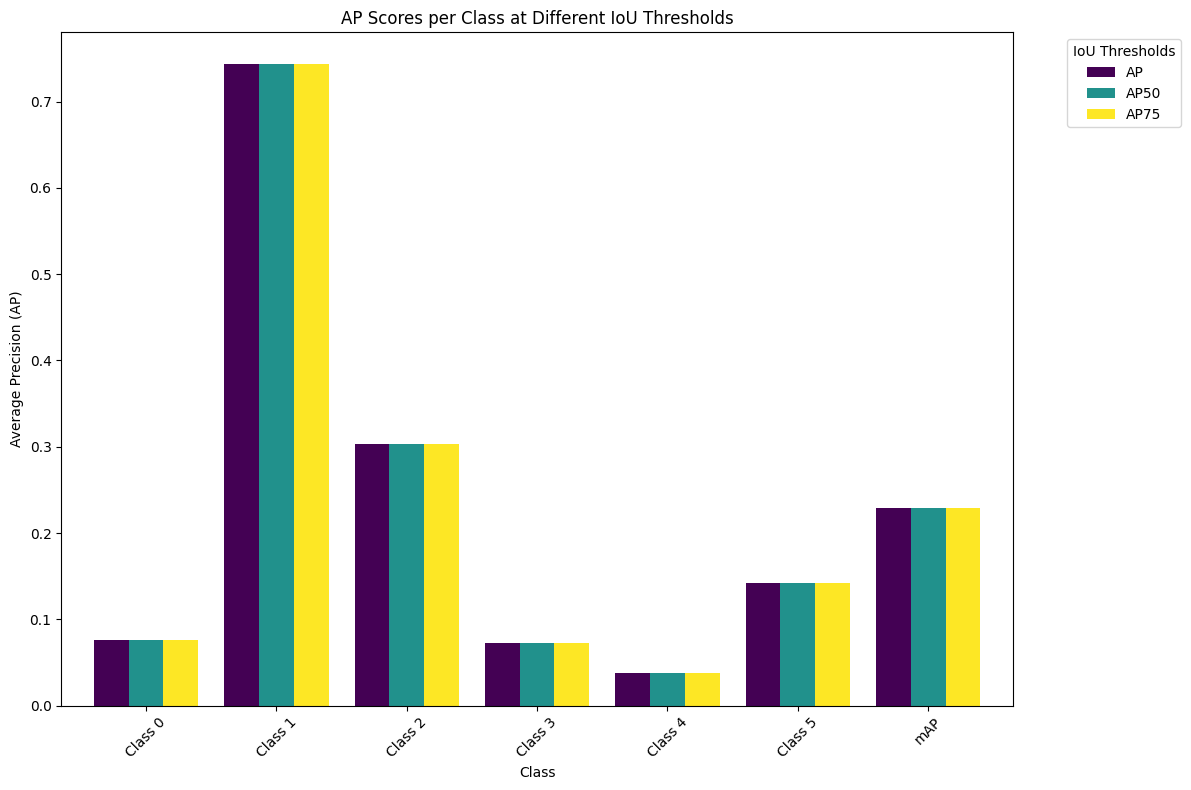

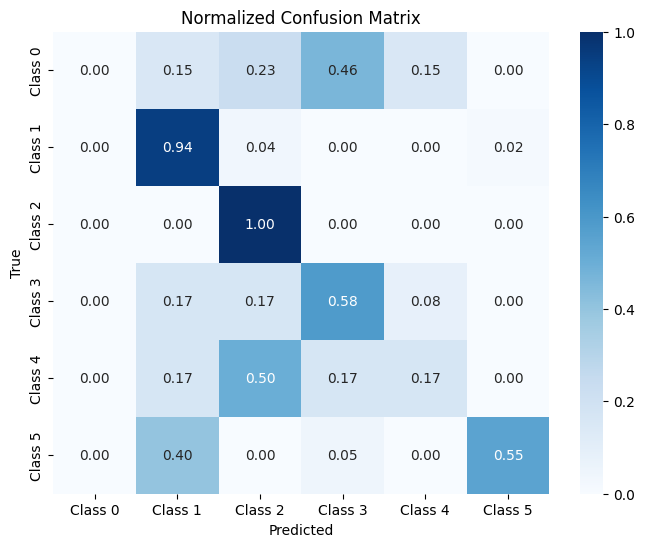

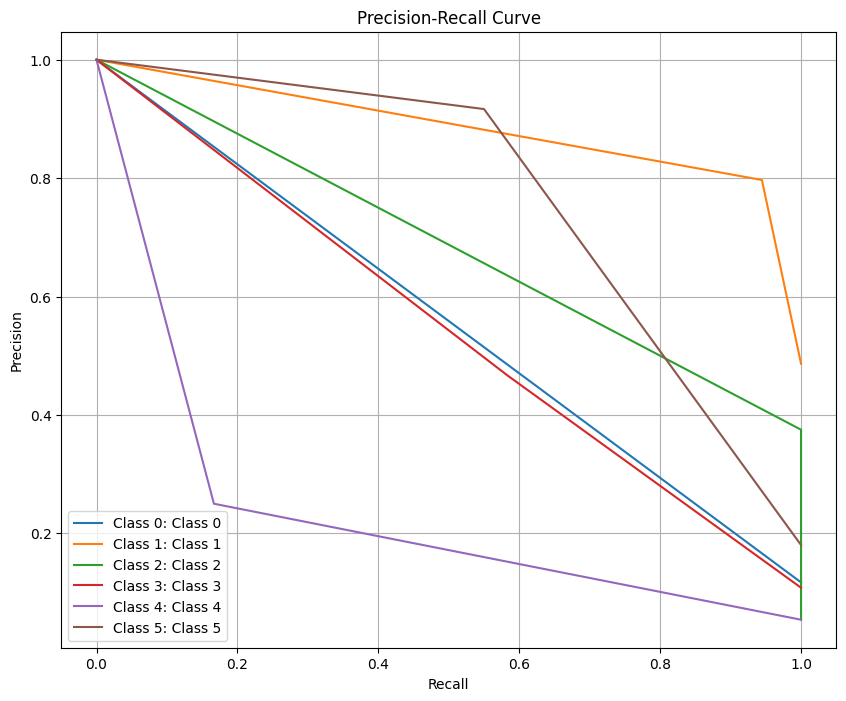


Precision, Recall, F1 Scores per Class:
     Class  Precision    Recall  F1 Score
0  Class 0   0.000000  0.000000  0.000000
1  Class 1   0.796875  0.944444  0.864407
2  Class 2   0.375000  1.000000  0.545455
3  Class 3   0.466667  0.583333  0.518519
4  Class 4   0.250000  0.166667  0.200000
5  Class 5   0.916667  0.550000  0.687500

Mean Precision: 0.4675
Mean Recall: 0.5407
Mean F1 Score: 0.4693


In [20]:
evaluate(model, test_data_loader, device, class_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])

In [21]:
images, targets = next(iter(test_data_loader))

In [22]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [23]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [24]:
model.eval()
cpu_device = torch.device("cpu")

with torch.no_grad():
    outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [25]:
outputs

[{'boxes': tensor([[2733.8005, 1656.3549, 3615.3821, 2306.7791],
          [3786.1350,  586.9921, 4029.2891, 1027.1851],
          [   4.7621,  971.0251,  119.0036, 1429.5441],
          [3758.8196,  576.5781, 4032.0000, 1125.8403],
          [ 241.8445, 1410.0615,  904.3916, 2368.9543],
          [2629.9407,  837.2612, 3828.1282, 1332.4341],
          [2688.7771, 1637.5688, 2820.9099, 1782.9794],
          [2597.6350, 1635.6096, 3626.3035, 2375.4258],
          [2748.0088,  869.8961, 3662.4844, 1243.6235],
          [3798.8701,  520.5978, 4030.5168, 1020.7489],
          [2359.3716, 1340.6096, 2640.4004, 1673.9039],
          [ 266.6211, 1353.1287,  868.8372, 2383.7273],
          [ 267.8665, 1420.5413,  845.1542, 2218.5537],
          [2694.6323, 1692.4443, 3626.8206, 2376.1599],
          [   0.0000,  890.0202,  128.6227, 1564.5883],
          [2718.9089, 1641.8303, 3342.0881, 2107.9187],
          [2728.1787, 1639.0714, 3579.4031, 2424.6072],
          [ 418.2025, 1950.8372,  905.0

(3024, 4032, 3)


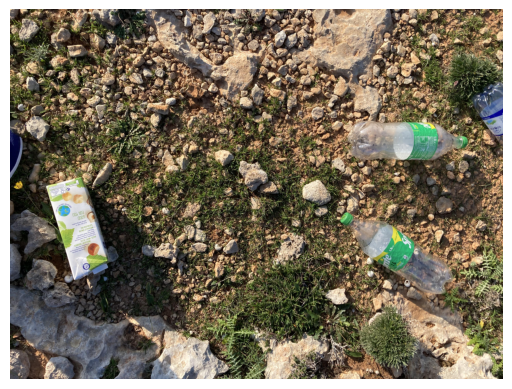

In [26]:
# Extract and reshape the image for the 2nd sample
sample_image = images[0].cpu().numpy()

# Keep only the first 3 RGB channels
red_channel = sample_image[0]
green_channel = sample_image[1]
blue_channel = sample_image[2]
# Edge channel will be ignored for now
# edge_channel = sample_image[3]

red_channel = (red_channel * 255).astype(np.uint8)
green_channel = (green_channel * 255).astype(np.uint8)
blue_channel = (blue_channel * 255).astype(np.uint8)

# Stack the channels to form the RGB image
sample_image_rgb = np.stack([red_channel, green_channel, blue_channel], axis=-1)

print(sample_image_rgb.shape)  # This should give you (height, width, 3) for RGB channels

# Plot the image using Matplotlib
plt.imshow(sample_image_rgb)
plt.axis('off')
plt.show()


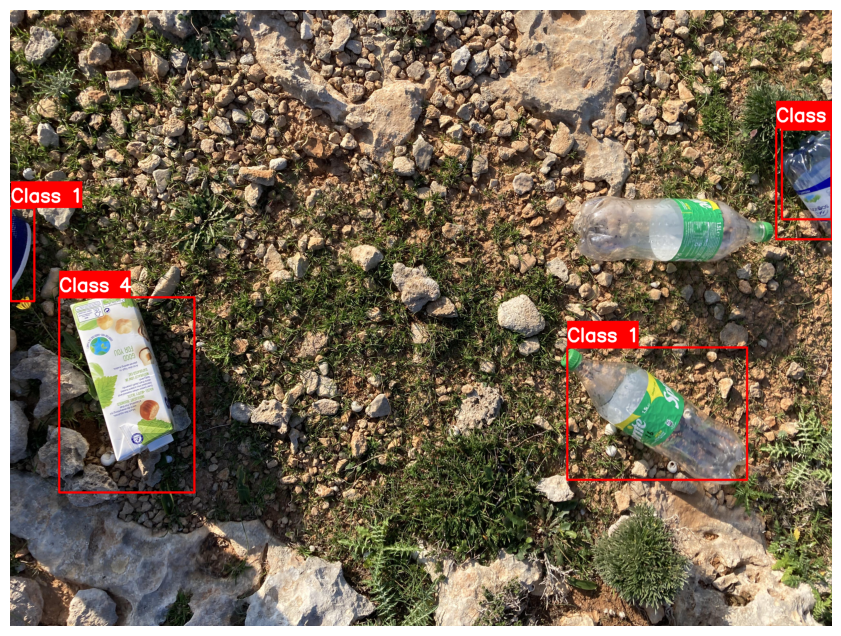

In [29]:
# Assuming `outputs` is the list of dictionaries and `sample_image_rgb` is your image
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Convert the image to uint8 (if not already in that format)
sample_image_rgb = sample_image_rgb.astype(np.uint8)

# Iterate over all the output (boxes and labels)
output = outputs[0]  # Example with the first output

# Remove outputs which have a score less than 0.5 (Non-maximum suppression)
keep = output['scores'] >= 0.3
output = {k: v[keep] for k, v in output.items()}  # Update the output dictionary

boxes = output['boxes'].detach().numpy()  # Move boxes from GPU to CPU and convert to NumPy
labels = output['labels'].detach().numpy()  # Get the labels for each box

# Iterate through all the boxes and labels
for i, box in enumerate(boxes):
    # The box is in the format [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = box

    # Convert the coordinates to integers
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Draw the rectangle (bounding box) on the image
    cv2.rectangle(sample_image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 10)

    # Draw the class label text
    class_id = labels[i]  # Class ID for the current box
    class_name = f'Class {class_id}'  # Class label name

    # Get the size of the text to adjust the background rectangle for text
    text_height = 100
    text_width = len(class_name) * 50

    # Draw the background rectangle for the class label text
    cv2.rectangle(sample_image_rgb, (x_min, y_min - int(1.3 * text_height)),
                  (x_min + text_width, y_min), (255, 0, 0), -1)

    # Put the class name text (make it bold and white)
    cv2.putText(sample_image_rgb, class_name, (x_min, y_min - int(0.3 * text_height)),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), thickness=10, lineType=cv2.LINE_AA)

# Remove axis for clarity in plotting
ax.set_axis_off()
ax.imshow(sample_image_rgb)
plt.show()


In [28]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn_100epochs.pth')